# Coursework 1 Test

In [1]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
from sklearn.preprocessing import normalize

# Load Dataset

(2576, 520)
(1, 520)
Number of face labels: 52
Image label: 1


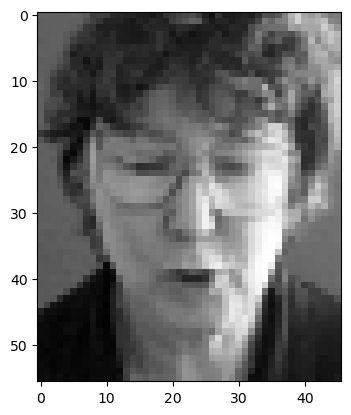

In [2]:
mat_file = io.loadmat('face.mat')

face_datas = mat_file['X']
face_labels = mat_file['l']

print(face_datas.shape) #520개의 image
print(face_labels.shape) #520개의 label
print("Number of face labels: {}".format(len(np.unique(face_labels))))

#Loading one image
imgnumn = 0
face_n = face_datas[:,imgnumn]
face_n = np.reshape(face_n,(46,56)).T
print("Image label: {}".format(face_labels[0,imgnumn]))
plt.imshow(face_n, cmap = 'gist_gray')

In [3]:
#train-test split
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(face_datas.T, face_labels.T, test_size=0.2, random_state=28)
#print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

In [4]:
#train-test split : 8 / 2 images for each ID
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
train_index, test_index = next(sss.split(face_datas.T, face_labels.T))

X_train, X_test = face_datas.T[train_index], face_datas.T[test_index]
y_train, y_test = face_labels.T[train_index], face_labels.T[test_index]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(416, 2576) (104, 2576) (416, 1) (104, 1)


(2576,)


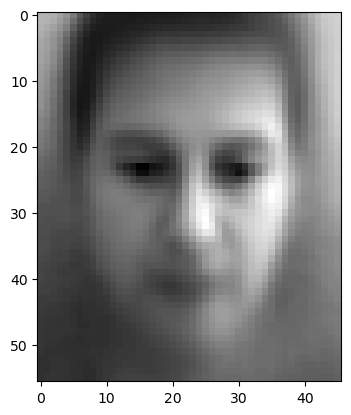

In [5]:
#Obtaining mean image
avg_face_numpy = np.mean(X_train, axis=0)
print(avg_face_numpy.shape)

plt.imshow(np.reshape(avg_face_numpy,(46,56)).T, cmap = 'gist_gray')

# 1. Computationally Efficient Eigenfaces

- Direct Computation

In [6]:
#Direct computation
mean_train = np.mean(X_train, axis=0)
A_train = X_train - mean_train
N_train = X_train.shape[0]
S_train = (A_train.T @ A_train) * (1/N_train)

#Record compute time
start_time = time.time()
eigvals, eigvecs = np.linalg.eig(S_train)
sec_original = time.time() - start_time
sec_original = str(datetime.timedelta(seconds=sec_original))
sec_original = float(sec_original.split(":")[2])
print("{} seconds passed".format(sec_original))

#sorting in top-down order
idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
eigvecs = eigvecs[:,idx]
print("num of nonzero eigenvalues: {}".format(np.sum(eigvals>0)))


(2576,)
16.234853 seconds passed
num of nonzero eigenvalues: 1486


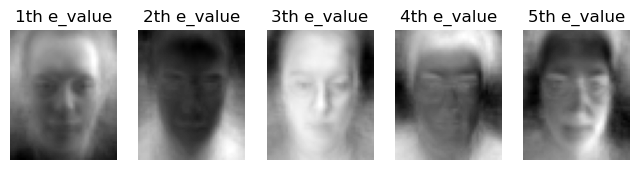

In [7]:
def face_visualizer(vector, facenum):
    f, axes = plt.subplots(1, int(facenum), figsize=(8,6))
    for i in range (facenum):
        tempvec = np.real(vector[:,i])
        axes = axes.flatten()
        a = axes[i]
        a.set_title("{}th e_value".format(i+1))
        a.axis('off')
        a.imshow(np.reshape(tempvec,(46,56)).T, cmap = 'gist_gray')
    plt.show()

face_visualizer(eigvecs,5)

(20, 2576)
(2576, 416)
[[155.80594154 148.91828553 149.65502404 ... 119.76968016 125.36172015
  126.84125211]
 [ 67.14713451  67.99220985  70.81992393 ... 196.45979115 195.01142717
  192.68308864]
 [128.84896723 134.13412382 139.93280276 ...  80.62494729  74.81812546
   67.73094566]
 ...
 [164.86139983 154.41796757 151.8199248  ... 130.10514937 137.38177528
  140.16988521]
 [180.74905644 189.8501771  195.75207889 ...  18.72125932  18.45769611
   19.17427396]
 [ 72.63681388  78.08661084  78.18811558 ... 184.15373846 177.87020601
  174.08471313]]


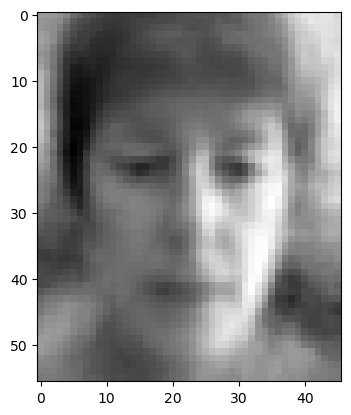

In [8]:
#face reconstruction

#avg_face_train
a = eigvecs.T[:20]
b = A_train.T
print(a.shape)
print(b.shape)

#reconst_face_low = np.real(a.T@a@b).T + mean_train
reconst_face = np.real(a.T@a@b).T + mean_train
print(reconst_face)

plt.imshow(np.reshape(reconst_face[0],(46,56)).T, cmap = 'gist_gray')

Reconstruction error for vecNum=10 is 24860.763427159574
Reconstruction error for vecNum=20 is 20698.9626136029
Reconstruction error for vecNum=50 is 15150.553712566501
Reconstruction error for vecNum=150 is 8272.033669273049
Reconstruction error for vecNum=300 is 3483.999061892317


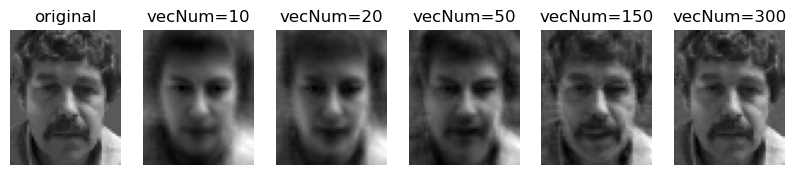

In [9]:
def reconstruction_visualizer(eigenvector, mlist, setnum):
    f, axes = plt.subplots(1, len(mlist)+1, figsize=(10,8))
    origina = axes[0]
    origina.set_title("original")
    origina.axis('off')
    origina.imshow(np.reshape(X_train[setnum],(46,56)).T, cmap = 'gist_gray')
    for i in range (len(mlist)):
        mym = mlist[i]
        first = eigenvector.T[:mym]
        second = A_train.T
        
        reconst_face = np.real(first.T@first@second).T + mean_train
        axes = axes.flatten()
        a = axes[i+1]
        a.set_title("vecNum={}".format(mym))
        a.axis('off')
        a.imshow(np.reshape(reconst_face[setnum],(46,56)).T, cmap = 'gist_gray')
        print("Reconstruction error for vecNum={} is {}".format(mym,np.linalg.norm(reconst_face-X_train)))
    plt.show()
    
reconstruction_visualizer(eigvecs,[10,20,50,150,300],15)

- Low-dimensional computation

(416, 416)
0.334437 seconds passed
(2576, 416)
num of nonzero eigenvalues: 415


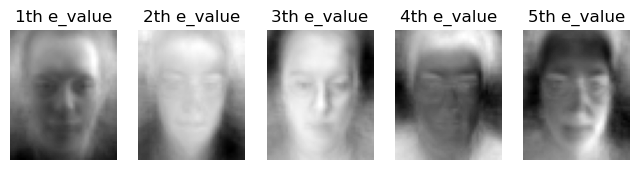

In [10]:
from sklearn.preprocessing import normalize
#Compute eigenvectors and eigenvalues (low-dimensional approach)

M_low =(A_train@A_train.T) * (1/N_train)
print(M_low.shape)

start_time = time.time()
eigvals_low, eigvecs_low = np.linalg.eig(M_low)
sec_low = time.time() - start_time
sec_low = str(datetime.timedelta(seconds=sec_low))
sec_low = float(sec_low.split(":")[2])
print("{} seconds passed".format(sec_low))

#sorting in top-down order
idx_low = eigvals_low.argsort()[::-1]   
eigvals_low = eigvals_low[idx_low]
eigvecs_low = eigvecs_low[:,idx_low]
eigvecs_low = A_train.T@eigvecs_low
print(eigvecs_low.shape)
eigvecs_low = normalize(eigvecs_low,axis=0)

print("num of nonzero eigenvalues: {}".format(np.sum(eigvals_low>0)))

face_visualizer(eigvecs_low,5)

- Comparison of eigenvectors/eigenvalues from 2 computation methods

In [11]:
print(np.real(eigvecs))
print(eigvecs_low)

[[ 0.01352238 -0.01353197 -0.01830687 ...  0.00349331  0.01125996
   0.00230031]
 [ 0.014529   -0.01425258 -0.01834581 ... -0.01432972  0.00589574
  -0.00463451]
 [ 0.01546867 -0.01307549 -0.01979569 ...  0.00181792  0.00978016
  -0.01320707]
 ...
 [-0.00683418  0.049698    0.00305583 ... -0.03149544  0.00849227
  -0.00424227]
 [-0.00715374  0.04921189  0.00282645 ... -0.00542092  0.01569791
  -0.01381779]
 [-0.00703489  0.05024461  0.00501326 ...  0.00583879 -0.02509139
   0.0016588 ]]
[[ 0.01352238  0.01353197 -0.01830687 ... -0.02772708  0.00827845
  -0.05377857]
 [ 0.014529    0.01425258 -0.01834581 ... -0.01355901  0.00030348
  -0.00707054]
 [ 0.01546867  0.01307549 -0.01979569 ...  0.01406266 -0.00240015
   0.01741401]
 ...
 [-0.00683418 -0.049698    0.00305583 ...  0.04324232 -0.03725381
  -0.00019987]
 [-0.00715374 -0.04921189  0.00282645 ...  0.01552133 -0.00628445
   0.04956873]
 [-0.00703489 -0.05024461  0.00501326 ...  0.00936901 -0.02914448
   0.05016835]]


(20, 2576)
(2576, 416)
[[155.80594154 148.91828553 149.65502404 ... 119.76968016 125.36172015
  126.84125211]
 [ 67.14713451  67.99220985  70.81992393 ... 196.45979115 195.01142717
  192.68308864]
 [128.84896723 134.13412382 139.93280276 ...  80.62494729  74.81812546
   67.73094566]
 ...
 [164.86139983 154.41796757 151.8199248  ... 130.10514937 137.38177528
  140.16988521]
 [180.74905644 189.8501771  195.75207889 ...  18.72125932  18.45769611
   19.17427396]
 [ 72.63681388  78.08661084  78.18811558 ... 184.15373846 177.87020601
  174.08471313]]


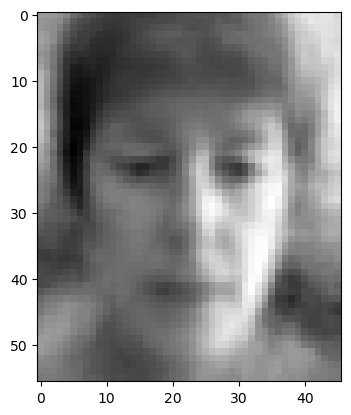

In [12]:
#face reconstruction

#avg_face_train
a = eigvecs_low.T[:20]
b = A_train.T
print(a.shape)
print(b.shape)

#reconst_face_low = np.real(a.T@a@b).T + mean_train
reconst_face_low = np.real(a.T@a@b).T + mean_train
print(reconst_face_low)

plt.imshow(np.reshape(reconst_face_low[0],(46,56)).T, cmap = 'gist_gray')

Reconstruction error for vecNum=10 is 24860.763427159574
Reconstruction error for vecNum=20 is 20698.9626136029
Reconstruction error for vecNum=50 is 15150.5537125665
Reconstruction error for vecNum=150 is 8272.033669273049
Reconstruction error for vecNum=300 is 3483.999061892317


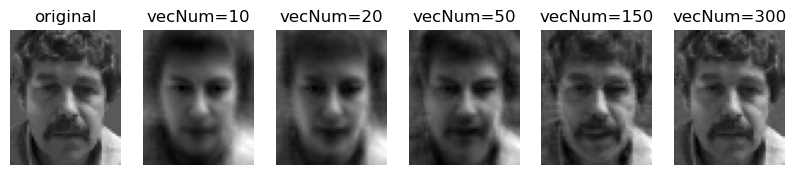

In [13]:
reconstruction_visualizer(eigvecs_low,[10,20,50,150,300],15)

# PCA using SKlearn

In [14]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

h, w = 46, 56
n_components = 200

print(
    "Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0])
)
t0 = time.time()
pca = PCA(n_components=n_components).fit(X_train)
print("done in %0.3fs" % (time.time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time.time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time.time() - t0))

Extracting the top 200 eigenfaces from 416 faces
done in 0.480s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.021s


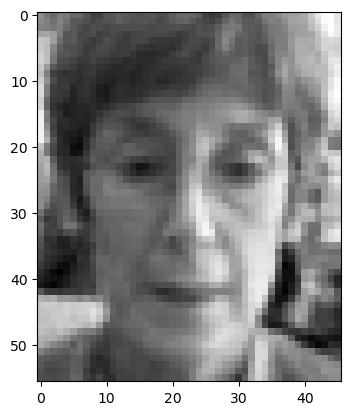

In [15]:
X_train_reconst = pca.inverse_transform(X_train_pca)
X_train_reconst_error = abs(X_train - X_train_reconst)

plt.imshow(np.reshape(X_train_reconst[0],(46,56)).T, cmap = 'gist_gray')

In [16]:
print("Fitting the classifier to the training set")
t0 = time.time()
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_train_pca, y_train.flatten())
print("done in %0.3fs" % (time.time() - t0))

Fitting the classifier to the training set
done in 0.001s


In [17]:
y_pred = clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         2
           3       0.67      1.00      0.80         2
           4       1.00      0.50      0.67         2
           5       1.00      1.00      1.00         2
           6       0.50      1.00      0.67         2
           7       1.00      0.50      0.67         2
           8       0.50      1.00      0.67         2
           9       1.00      0.50      0.67         2
          10       1.00      1.00      1.00         2
          11       0.50      0.50      0.50         2
          12       0.67      1.00      0.80         2
          13       1.00      0.50      0.67         2
          14       1.00      0.50      0.67         2
          15       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          17       0.50      0.50      0.50         2
          18       1.00    

/Users/cwwojin/opt/anaconda3/envs/cs492_vision/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/cwwojin/opt/anaconda3/envs/cs492_vision/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/cwwojin/opt/anaconda3/envs/cs492_vision/lib/python3.9/site-packages/